# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/03 12:12:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/03 12:12:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/03 12:12:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Load data

## Regions

In [4]:
indy = Region.load('Indianapolis', 'Indiana')
aus = Region.load('Austin', 'Texas')
hous = Region.load('Houston', 'Texas')

rgns = [aus, hous, indy]

## Study periods

In [5]:
indy.dates = U.dates('2021-03-01', '2021-03-07')
aus.dates = U.dates('2021-07-01', '2021-07-07')
hous.dates = U.dates('2021-07-01', '2021-07-07')

## City boundaries

In [6]:
def load_boundary(rgn):
    return gpd.read_file(MK / f'general/data/cities/{rgn}/boundary.gpkg')

indy.boundary = load_boundary(indy)
aus.boundary = load_boundary(aus)
hous.boundary = load_boundary(hous)

## User quality

In [7]:
def get_user_ping_count(rgn):
    return (SP.read_parquet(rgn.data / 'counts')
            .groupby(UID).agg(F.sum('n_pings').alias('n_pings'))
            .sort(F.col('n_pings').desc()).toPandas())

In [8]:
indy.user_ping_count = get_user_ping_count(indy).disp()
aus.user_ping_count = get_user_ping_count(aus)
hous.user_ping_count = get_user_ping_count(hous)

885,553 rows x 2 cols; Memory: 13.5 MiB


,uid,n_pings
,<int64>,<int64>
0,-5882161734607420112,68630


## Homes

In [9]:
algos = ['A0', 'A1', 'A2', 'A3']
algo_colors = sns.color_palette('Set1', len(algos))

In [10]:
summary = []
for rgn, alg in it.product(rgns, algos):
    try:
        df = pd.read_parquet(rgn.data / f'home_locs/{alg}.parquet')
        if alg == 'A3': df = df.query('~used_mean').drop(columns='used_mean')
        setattr(rgn, alg, df)
        summary.append(dict(algorithm=alg, city=rgn.name, n_users=len(df)))
    except FileNotFoundError:
        pass
Pdf(summary).pivot(index='city', columns='algorithm', values='n_users')

algorithm,A0,A1,A2,A3
city,,,,
Austin,44005,44005,44005,74019
Houston,147651,147651,147651,250220
Indianapolis,63295,63295,63295,48154


# Lorenz curves

## User-ping count tradeoff

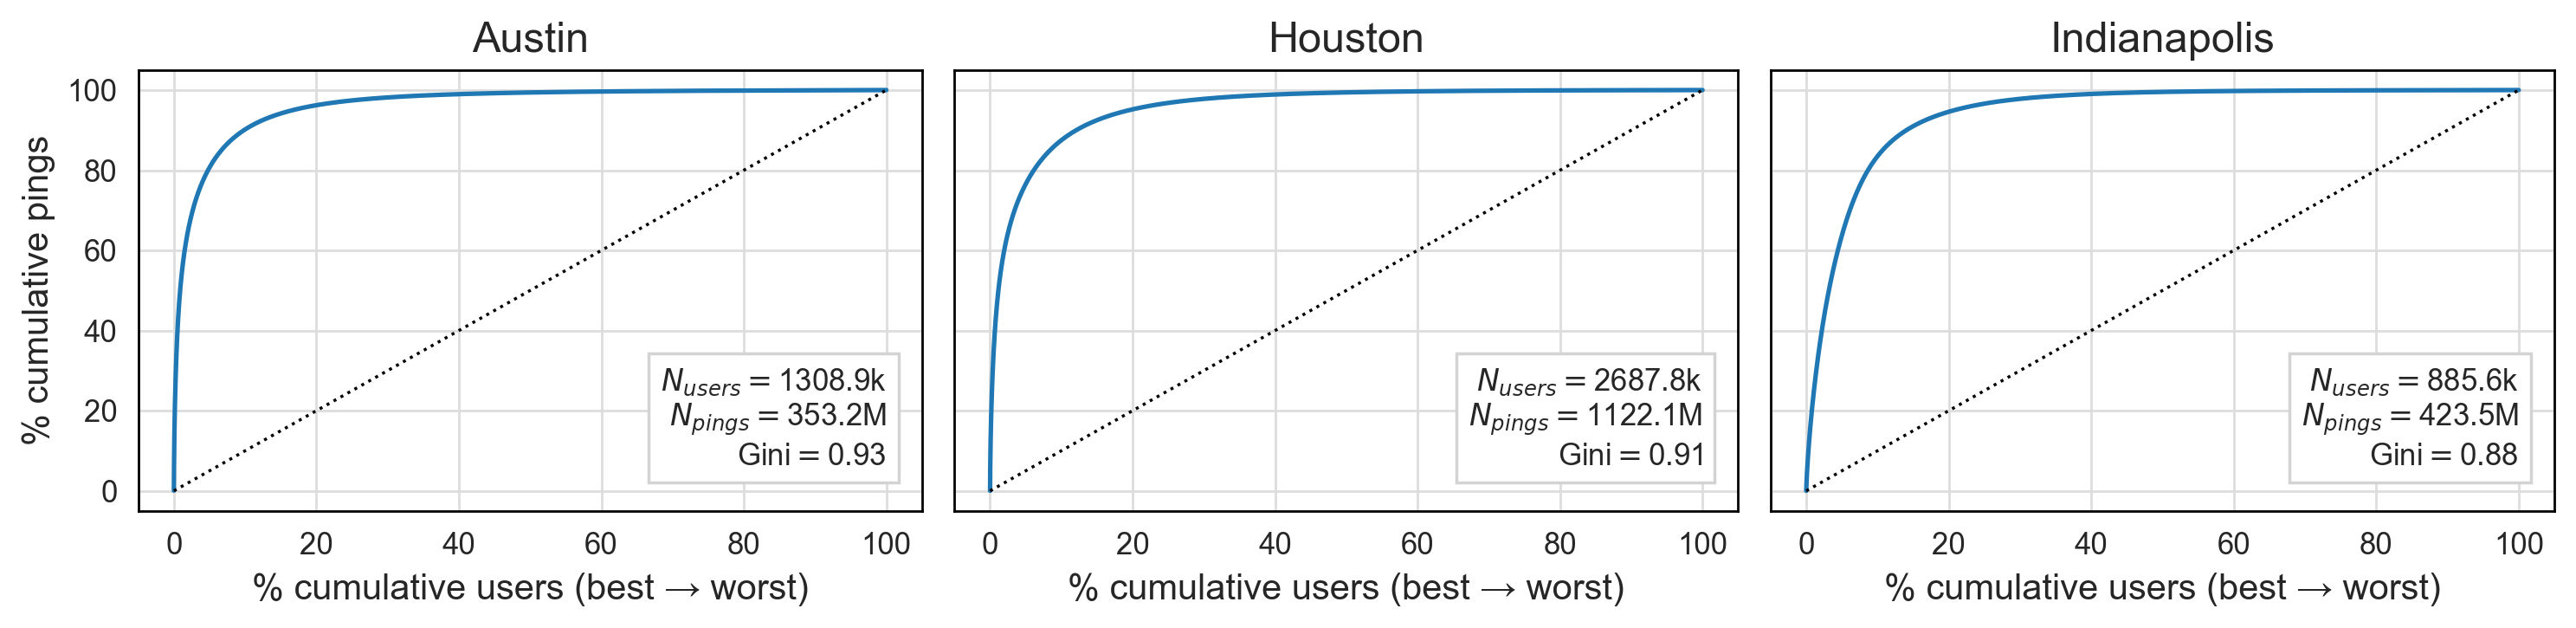

In [11]:
def get_user_ping_count_lorenz_curve(rgns, size=(4, 3), dpi=120):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        y = rgn.user_ping_count['n_pings']
        nUsers, nPings = len(y), sum(y)
        y = y.cumsum() / y.sum()
        ax = U.plot(ax, title=rgn.name, xlab='% cumulative users (best → worst)',
                    gridcolor='#ddd', ylab='% cumulative pings' if i == 0 else '',
                    framebordercolor='k')
        ax.plot(y.index / len(y) * 100, y * 100)
        ax.plot([0, 100], [0, 100], ls=':', lw=1, color='k')
        gini = 2 * (y.sum() / len(y)) - 1
        ax.text(100, 5, '$N_{users}=$%.1fk\n$N_{pings}=$%.1fM\nGini$=$%.2f' %
                (nUsers / 1000, nPings / 1e6, gini), va='bottom', ha='right',
                bbox=dict(facecolor='w', edgecolor='lightgrey'))
    plt.tight_layout()
    P.imsave('User-ping count Lorenz curve - {}'.format(
        ', '.join([rgn.name for rgn in rgns])))

get_user_ping_count_lorenz_curve([aus, hous, indy], dpi=250)

## M1: Residential area

### Load the buffers

In [12]:
def get_resi_buffers(rgn, max_buffer=np.inf):
    paths = [f for f in (rgn.geom / 'residential').glob('*.parquet') 
             if int(f.stem) <= max_buffer]
    resi = (pd.concat([gpd.read_parquet(f) for f in tqdm(paths)])
            .set_index('buffer').sort_index())
    resi = gpd.clip(resi.to_crs(CRS_DEG), rgn.boundary)
    return resi
    
# %time x = get_resi_buffers(indy, max_buffer=400); x

In [13]:
%time indy.R = get_resi_buffers(indy, max_buffer=200) # t=13s

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 9.86 s, sys: 1.12 s, total: 11 s
Wall time: 11 s


In [14]:
%time aus.R = get_resi_buffers(aus, max_buffer=200) # t=12s

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 9.52 s, sys: 1.1 s, total: 10.6 s
Wall time: 10.6 s


In [15]:
%time hous.R = get_resi_buffers(hous, max_buffer=200) # t=44s

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 32.5 s, sys: 5 s, total: 37.5 s
Wall time: 37.4 s


### Compute performance

In [16]:
def get_lu_detection_rate(rgn, alg, dates=None, max_buffer=200, bins=100):
    dates = sorted(dates or rgn.dates)
    users = (SP.read_parquet(rgn.data / f'night_pings/{dates[0]}_{dates[-1]}')
             .withColumn('n_pings', F.size(LON))
             .groupby(UID).agg(F.sum('n_pings').alias('n_pings'))
             .sort(F.col('n_pings').desc()).toPandas())
    homes = getattr(rgn, alg).copy()
    homes = mk.geo.pdf2gdf(homes, LON, LAT, CRS_DEG).set_index(UID)
    homes = gpd.sjoin(homes, rgn.boundary[['geometry']], 
                      predicate='within').drop(columns='index_right')
    users = users.merge(homes.reset_index()[[UID]], on=UID)
    n_homes = len(homes)
    resi = rgn.R[rgn.R.index <= max_buffer] if max_buffer else rgn.R
    y, nU = [], []
    for buffer, row in resi.sort_index().iterrows():
        resi = Gdf({'geometry': [row.geometry]}, crs=CRS_DEG)
        within = gpd.sjoin(homes, resi, predicate='within').index
        within = Pdf({'present': True}, index=within)
        df = users.merge(within, how='left', on=UID).fillna(False)
        slices = np.linspace(0, len(df)+1, bins).astype(int)[1:]
        y.append(Seq([df.iloc[:idx]['present'].sum() for idx in slices], name=buffer))
    y = pd.concat(y, axis=1).T
    m1 = y.apply(lambda x: (x * (x.index.max() - x.index)).sum() / 
                   (x.sum() * x.index.max()))
    return m1

%time x = get_lu_detection_rate(indy, 'A1'); x

CPU times: user 4.57 s, sys: 556 ms, total: 5.13 s
Wall time: 6.58 s


0     0.662960
1     0.669252
2     0.670929
3     0.671934
4     0.673411
        ...   
94    0.686750
95    0.686746
96    0.686746
97    0.686780
98    0.686772
Length: 99, dtype: float64

CPU times: user 57.9 s, sys: 2.33 s, total: 1min
Wall time: 1min 9s


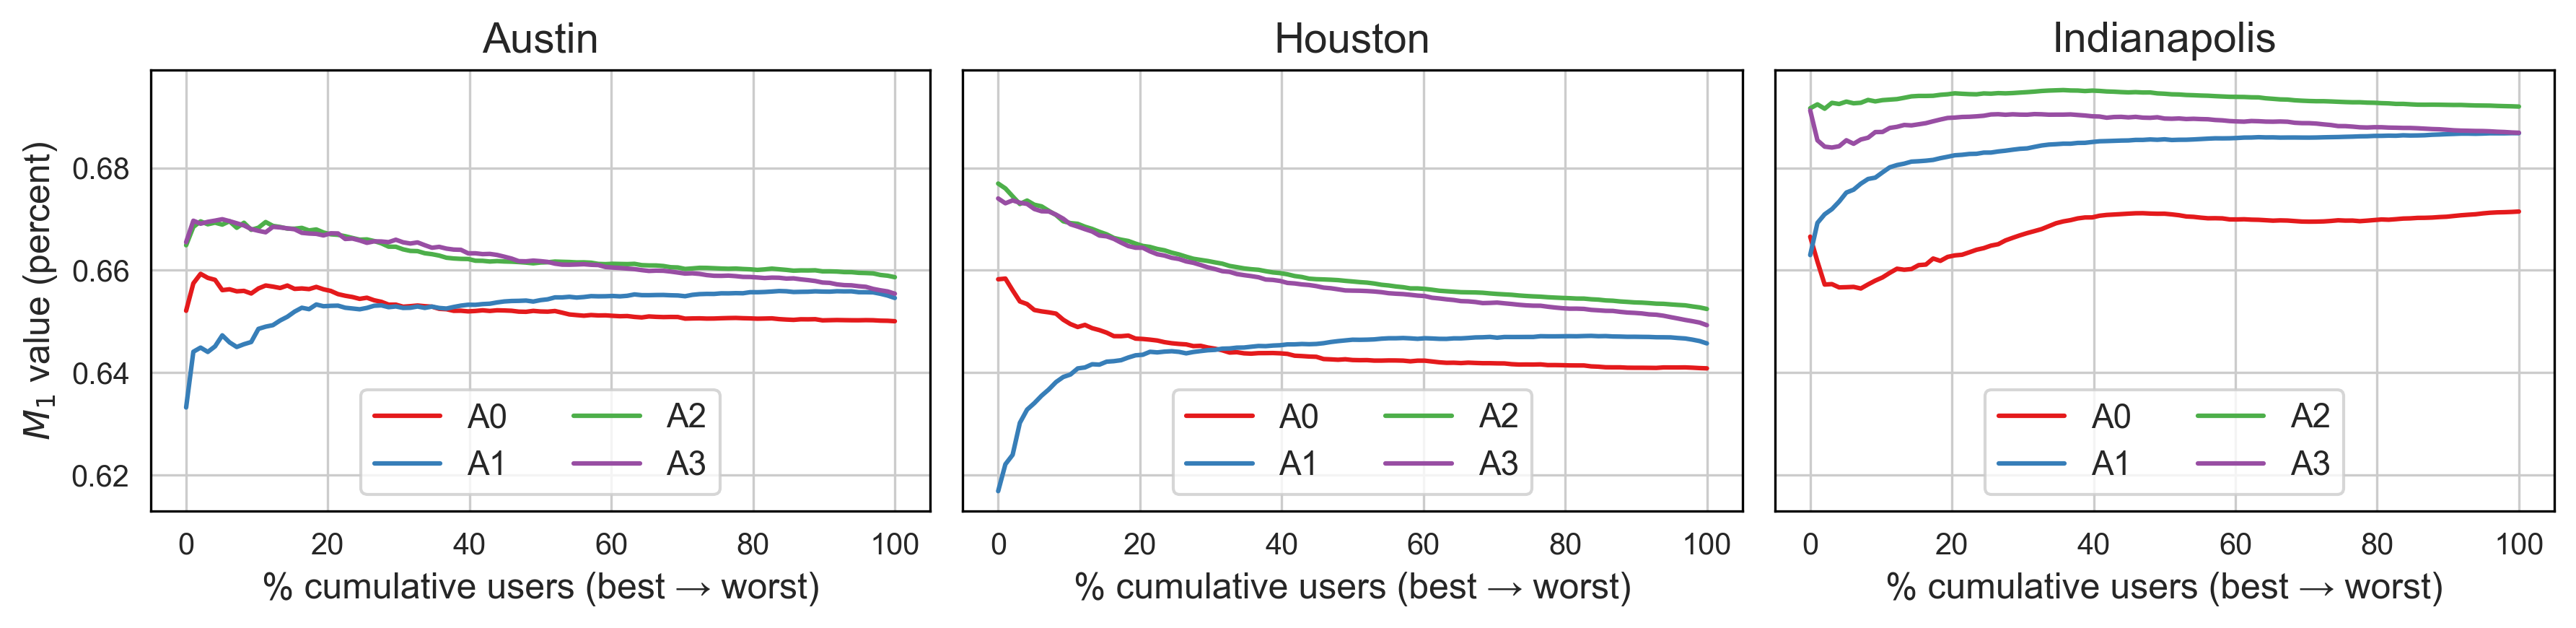

In [23]:
def get_m1_lorenz_curve(rgns, algos, agg_fn=np.median, colors=algo_colors, 
                        size=(4, 3), dpi=120, bins=100):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        for alg, color in zip(algos, colors):
            m1 = get_lu_detection_rate(rgn, alg)
            ax.plot(np.linspace(0, 100, len(m1)), m1, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_1$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M1 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m1_lorenz_curve(rgns, algos, dpi=300); x

## M2: Trajectory proximity

In [25]:
SP.start()

In [26]:
def dist_deg2m(angle, lat, a=6_371_001, b=6_356_752):
    """ Convert angular distance from degrees to meters at given latitude. """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
        (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(curve_radius * np.deg2rad(angle))

In [28]:
def get_proximity(rgn, alg, dates=None):
    dates = sorted(dates or rgn.dates)
    homes = (SP.read_parquet(rgn.data / f'home_locs/{alg}.parquet')
             .select(UID, *[F.col(x).cast(T.float).alias('home_'+x) for x in [LON, LAT]]))
    df = SP.read_parquet(rgn.data / f'night_pings/{dates[0]}_{dates[-1]}')
    df = df.join(homes, on=UID)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('dist', F.udf(dist4home, T.float)(LON, LAT, 'home_'+LON, 'home_'+LAT))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    return df
    
get_proximity(indy, 'A1')

DataFrame[uid: bigint, day: smallint, n_pings: smallint, dist: float]

In [29]:
%%time
# t=26s
for rgn in tqdm(rgns):
    rgn.traj_proxi = {alg: get_proximity(rgn, alg).toPandas() for alg in algos}

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 560 ms, sys: 259 ms, total: 819 ms
Wall time: 41.8 s


In [30]:
indy.traj_proxi['A1'].head(3)

,uid,day,n_pings,dist
0,-9216156493784366246,0,2,9.993794
1,-9216156493784366246,1,13,2.711407
2,-9216156493784366246,2,6,12.221523


CPU times: user 6.58 s, sys: 402 ms, total: 6.98 s
Wall time: 6.36 s


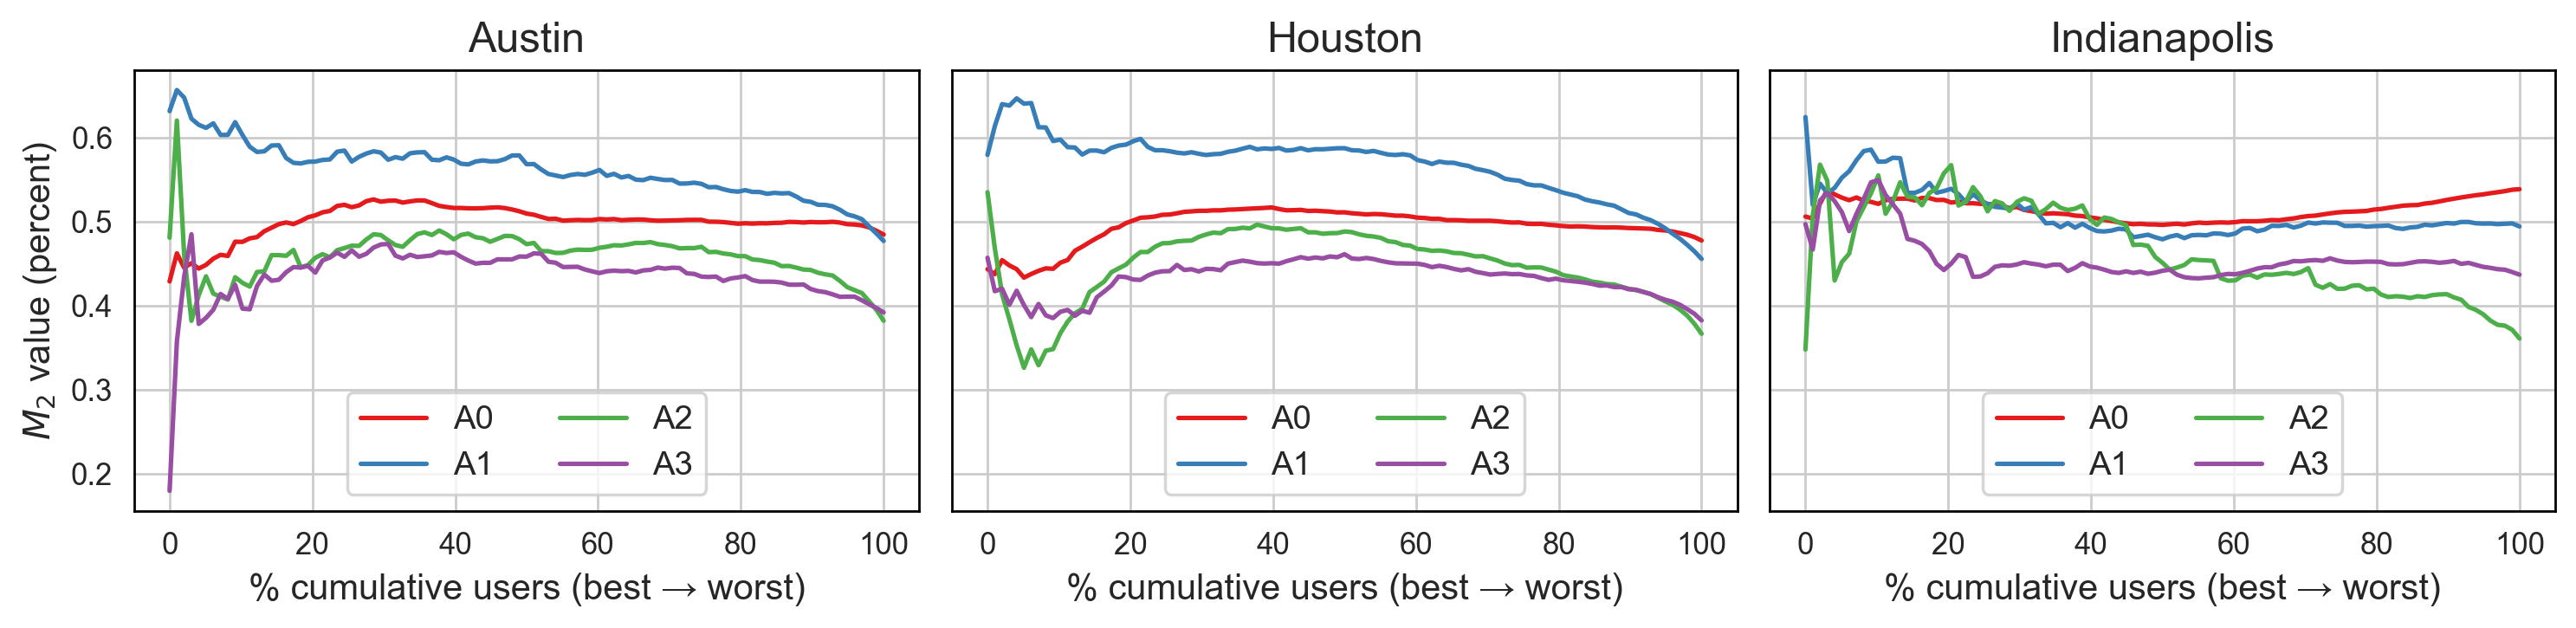

In [31]:
def get_m2_lorenz_curve(rgns, algos, agg_fn=np.median, colors=algo_colors,
                        size=(4, 3), dpi=120, bins=100):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        for alg, color in zip(algos, colors):
            df = (rgn.traj_proxi[alg].drop(columns=['n_pings'])
                  .groupby(UID)['dist'].agg(agg_fn).reset_index()
                  .merge(rgn.user_ping_count, on=UID)
                  .sort_values('n_pings', ascending=False)
                  .drop(columns='n_pings').reset_index(drop=True))
            m2 = []
            for idx in np.linspace(0, len(df)+1, bins).astype(int)[1:]:
                y = df.loc[:idx]['dist']
                y = y.cumsum() / y.sum()
                m2.append(y.sum() / len(y))
            ax.plot(np.linspace(0, 100, len(m2)), m2, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_2$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M2 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m2_lorenz_curve(rgns, algos, dpi=250); x

# Discrete Lorenz curves

## User-ping count tradeoff

CPU times: user 1.95 s, sys: 378 ms, total: 2.33 s
Wall time: 1.69 s


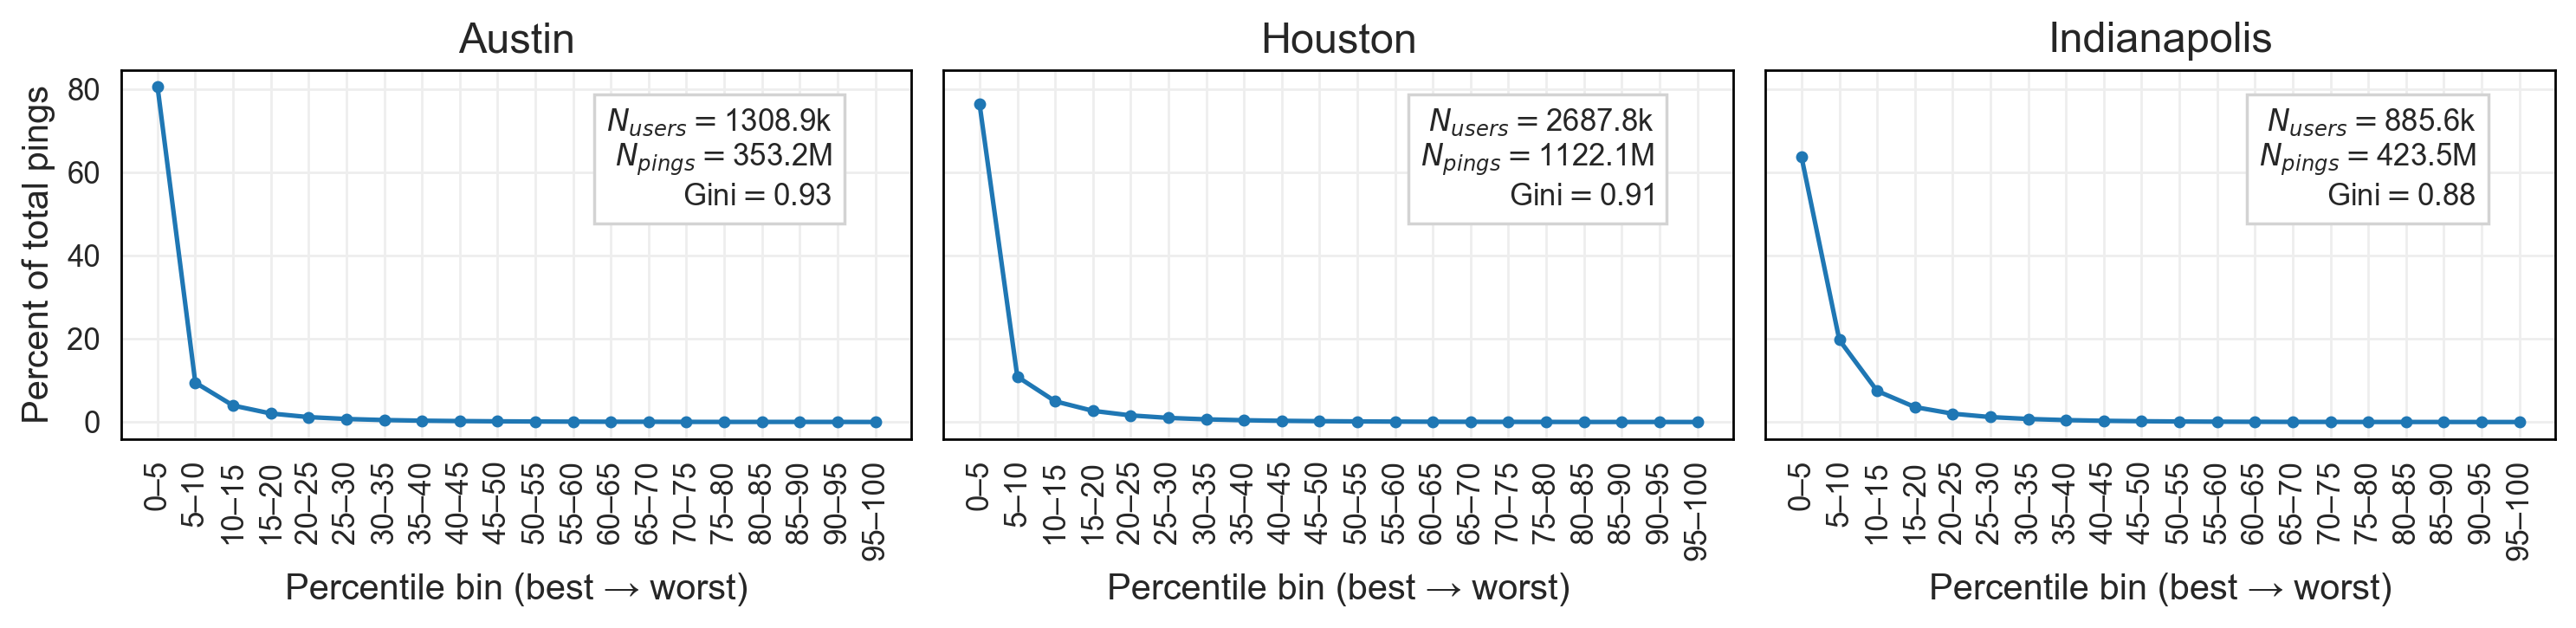

In [95]:
def get_user_ping_count_lorenz_curve(rgns, bins=20, size=(4, 3), dpi=120):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        df = rgn.user_ping_count[['n_pings']]
        df['bin'] = pd.cut(df.index, bins, include_lowest=True).codes + 1
        nUsers, nPings = len(df), df['n_pings'].sum()
        y = df.groupby('bin')['n_pings'].sum()
        x = np.linspace(0, 100, bins+1)
        x = [f'{int(x[i])}–{int(x[i+1])}' for i in range(len(x) - 1)]
        ax = U.plot(ax, title=rgn.name, xlab='Percentile bin (best → worst)',
                    gridcolor='#eee', framebordercolor='k',
                    ylab='Percent of total pings' if i == 0 else '')
        ax.plot(x, y / y.sum() * 100, marker='.')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ax.set_xticklabels(x, rotation=90)
        y = df['n_pings'].cumsum() / df['n_pings'].sum()
        gini = 2 * (y.sum() / len(y)) - 1
        ax.text(0.9, 0.9, '$N_{users}=$%.1fk\n$N_{pings}=$%.1fM\nGini$=$%.2f' %
                (nUsers / 1000, nPings / 1e6, gini), va='top', ha='right',
                bbox=dict(facecolor='w', edgecolor='lightgrey'),
                transform=ax.transAxes)
        # ax.xaxis.grid(False)
    plt.tight_layout()
    P.imsave('Discrete user-ping count Lorenz curve - {}'.format(
        ', '.join([rgn.name for rgn in rgns])))

%time get_user_ping_count_lorenz_curve([aus, hous, indy], dpi=250)

## M1: Residential area

In [108]:
def get_lu_detection_rate(rgn, alg, max_buffer=200, bins=20):
    users = rgn.user_ping_count
    users['bin'] = pd.cut(users.index, bins, include_lowest=True).codes + 1
    homes = getattr(rgn, alg).copy()
    homes = mk.geo.pdf2gdf(homes, LON, LAT, CRS_DEG).set_index(UID)
    homes = gpd.sjoin(homes, rgn.boundary[['geometry']], 
                      predicate='within').drop(columns='index_right')
    users = users.merge(homes.reset_index()[[UID]], on=UID)
    nUsers = len(users)
    resi = rgn.R[rgn.R.index <= max_buffer] if max_buffer else rgn.R
    y, nU = [], []
    for buffer, row in resi.sort_index().iterrows():
        resi = Gdf({'geometry': [row.geometry]}, crs=CRS_DEG)
        within = gpd.sjoin(homes, resi, predicate='within').index
        within = Pdf({'present': True}, index=within)
        df = users.merge(within, how='left', on=UID).fillna(False)
        df = df.query('present').groupby('bin').size().rename('n_users')
        return df
        slices = np.linspace(0, len(df)+1, bins).astype(int)[1:]
        y.append(Seq([df.iloc[:idx]['present'].sum() for idx in slices], name=buffer))
    y = pd.concat(y, axis=1).T
    m1 = y.apply(lambda x: (x * (x.index.max() - x.index)).sum() / 
                   (x.sum() * x.index.max()))
    return m1

%time x = get_lu_detection_rate(indy, 'A1'); x

CPU times: user 1.09 s, sys: 11.7 ms, total: 1.1 s
Wall time: 1.1 s


bin
1     8657
2     4810
3     1556
4      542
5      230
6       65
7       23
8        4
11       1
Name: n_users, dtype: int64

CPU times: user 57.9 s, sys: 2.33 s, total: 1min
Wall time: 1min 9s


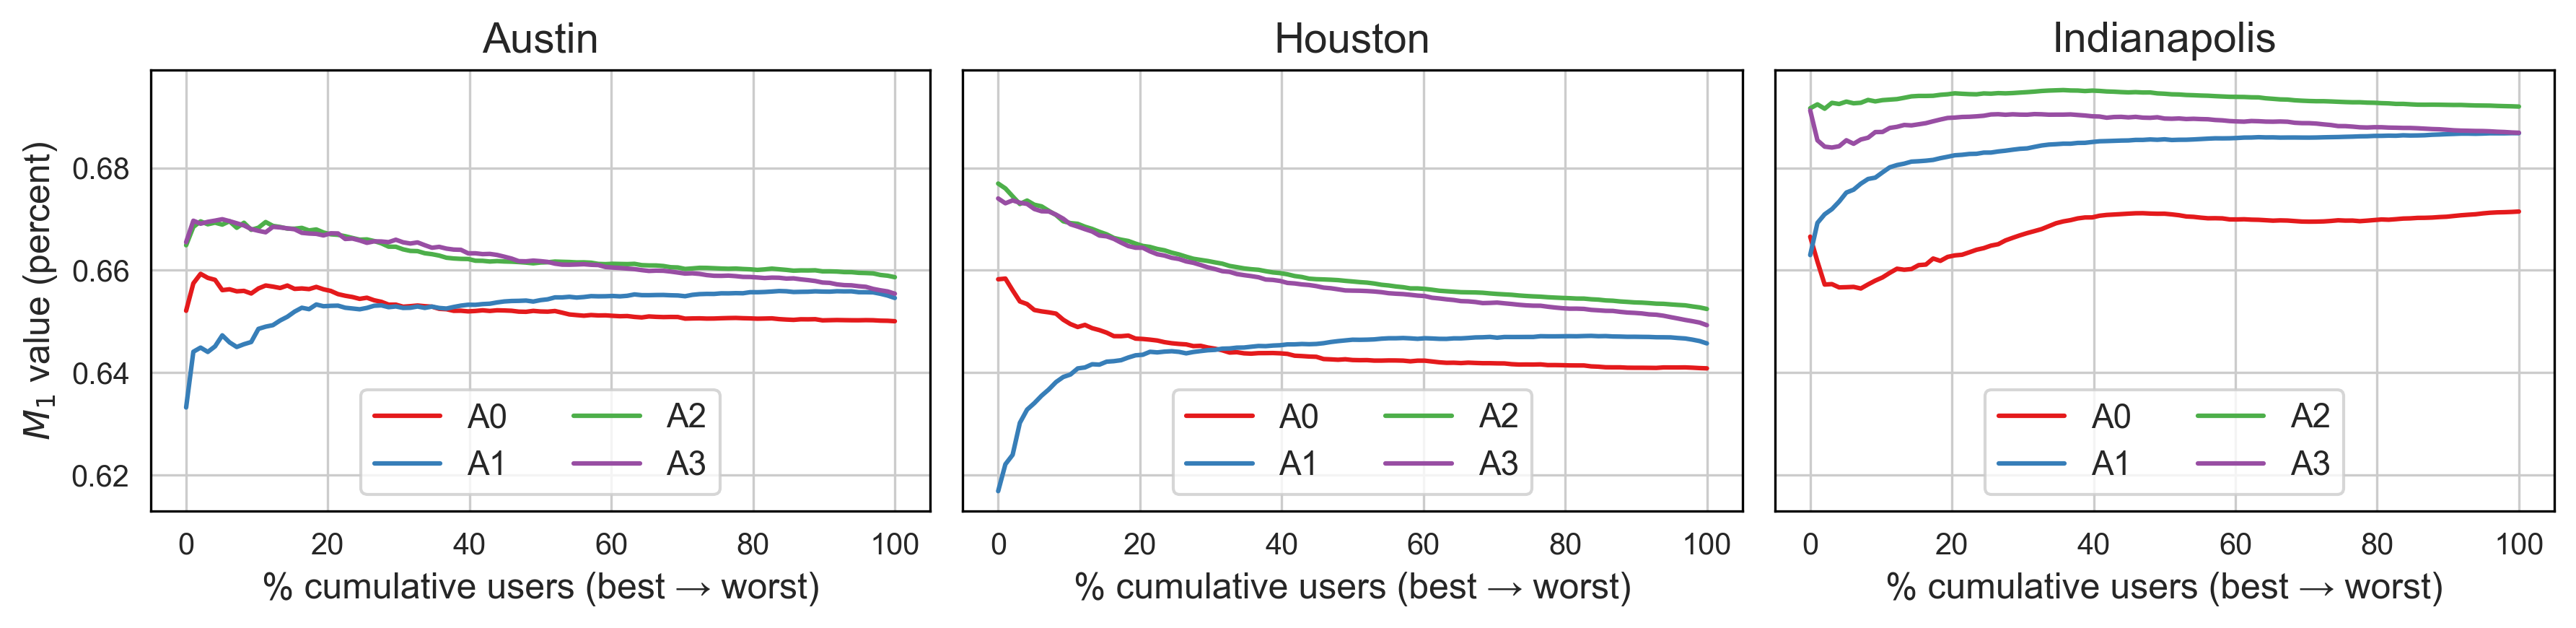

In [23]:
def get_m1_lorenz_curve(rgns, algos, agg_fn=np.median, colors=algo_colors, 
                        size=(4, 3), dpi=120, bins=100):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        for alg, color in zip(algos, colors):
            m1 = get_lu_detection_rate(rgn, alg)
            ax.plot(np.linspace(0, 100, len(m1)), m1, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_1$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M1 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m1_lorenz_curve(rgns, algos, dpi=300); x

## M2: Trajectory proximity

In [25]:
SP.start()

In [26]:
def dist_deg2m(angle, lat, a=6_371_001, b=6_356_752):
    """ Convert angular distance from degrees to meters at given latitude. """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
        (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(curve_radius * np.deg2rad(angle))

In [28]:
def get_proximity(rgn, alg, dates=None):
    dates = sorted(dates or rgn.dates)
    homes = (SP.read_parquet(rgn.data / f'home_locs/{alg}.parquet')
             .select(UID, *[F.col(x).cast(T.float).alias('home_'+x) for x in [LON, LAT]]))
    df = SP.read_parquet(rgn.data / f'night_pings/{dates[0]}_{dates[-1]}')
    df = df.join(homes, on=UID)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('dist', F.udf(dist4home, T.float)(LON, LAT, 'home_'+LON, 'home_'+LAT))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    return df
    
get_proximity(indy, 'A1')

DataFrame[uid: bigint, day: smallint, n_pings: smallint, dist: float]

In [29]:
%%time
# t=26s
for rgn in tqdm(rgns):
    rgn.traj_proxi = {alg: get_proximity(rgn, alg).toPandas() for alg in algos}

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 560 ms, sys: 259 ms, total: 819 ms
Wall time: 41.8 s


In [30]:
indy.traj_proxi['A1'].head(3)

,uid,day,n_pings,dist
0,-9216156493784366246,0,2,9.993794
1,-9216156493784366246,1,13,2.711407
2,-9216156493784366246,2,6,12.221523


CPU times: user 6.58 s, sys: 402 ms, total: 6.98 s
Wall time: 6.36 s


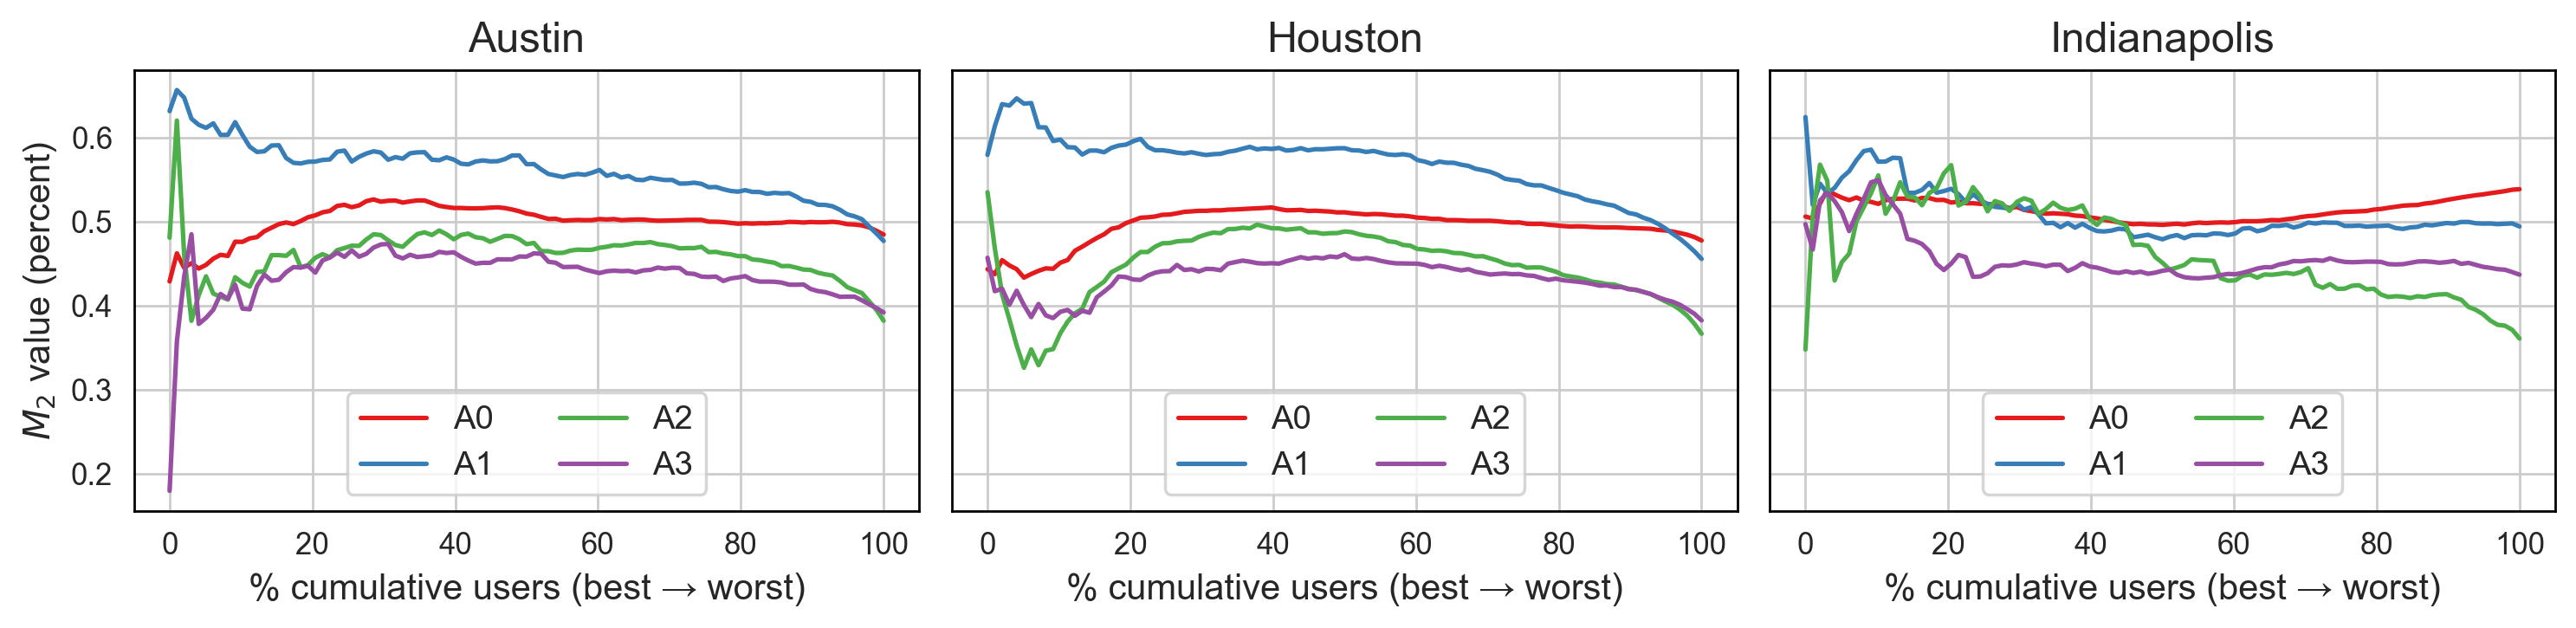

In [31]:
def get_m2_lorenz_curve(rgns, algos, agg_fn=np.median, colors=algo_colors,
                        size=(4, 3), dpi=120, bins=100):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        for alg, color in zip(algos, colors):
            df = (rgn.traj_proxi[alg].drop(columns=['n_pings'])
                  .groupby(UID)['dist'].agg(agg_fn).reset_index()
                  .merge(rgn.user_ping_count, on=UID)
                  .sort_values('n_pings', ascending=False)
                  .drop(columns='n_pings').reset_index(drop=True))
            m2 = []
            for idx in np.linspace(0, len(df)+1, bins).astype(int)[1:]:
                y = df.loc[:idx]['dist']
                y = y.cumsum() / y.sum()
                m2.append(y.sum() / len(y))
            ax.plot(np.linspace(0, 100, len(m2)), m2, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_2$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M2 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m2_lorenz_curve(rgns, algos, dpi=250); x